In [1]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, VGG16

from art.estimators.classification import KerasClassifier

from art.attacks.evasion import SpatialTransformation
from art.attacks.evasion import FastGradientMethod

from art.defences.trainer import AdversarialTrainer

# from art.utils import load_mnist
from art.utils import load_dataset

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
# sn.set() #this changes the style of all plots, and imshow shows up wrong
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.externals import joblib

import time
import platform
import subprocess
import shutil
import load10_temp as ltemp

try:
    import tensorflow as tf
    # tf.config.run_functions_eagerly(False)
    tf.compat.v1.disable_eager_execution()
except:
    print("Failed to disable tensorflow eager execution")

Using TensorFlow backend.


In [2]:
# img_size = 32
# img_size = 176
# img_size = 180
img_size = 224
# img_size = 512

render_util_folder = os.getcwd()
if (platform.system() == "Windows"):
    blender_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\blender-2.78c-windows64" 
    dataset_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\Greebles_3DS_10"
else:
    blender_folder = r"/home/ec1018/projects/blender-2.78c-linux-glibc219-x86_64"
    dataset_folder = r"/home/ec1018/projects/Greebles_3DS_10"

render_folder = os.path.join(os.getcwd(), "greebles_10") #reduced dataset of 10

# Delete folder - comment and uncomment as you need
# if os.path.exists(render_folder) and os.path.isdir(render_folder):
#     shutil.rmtree(render_folder)
    
if not os.path.isdir(dataset_folder):
    raise OSError(2, 'No such directory', str(dataset_folder))
if not os.path.exists(os.path.join(render_util_folder, 'render.py')):
    raise OSError(2, 'render.py not found', str(render_util_folder))

render_script = os.path.join(render_util_folder, 'render.py')

# Find the correct version of blender depending on the OS
if (platform.system() == "Windows"):
    blender_exec = os.path.join(blender_folder, 'blender.exe')
else:
    blender_exec = os.path.join(blender_folder, 'blender')
    
if not os.path.exists(os.path.join(blender_folder, blender_exec)):
    raise OSError(2, 'Blender executable not found', str(blender_folder))

# If you want to split command automatically
# import shlex; shlex.split("/bin/prog -i data.txt -o \"more data.txt\"")
# https://janakiev.com/blog/python-shell-commands/


set_mode = 'specific_all'
set_type = 'specific_angle'
#####################################
# Generate training set
blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                    '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                    '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', '0'])

# Move training set to folder                    
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
ltemp.move_to_folder(source_folder, os.path.join(source_folder, "train"))

In [3]:
# Step 1: Get training set

(x_train, y_train) = ltemp.load_dataset_temp("train", source_folder)
x_train = np.array(x_train, dtype='float64')
y_train = np.array(y_train, dtype='float32')

print(x_train.shape)
print(y_train.shape)
y_train

(10, 224, 224, 1)
(10, 10)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [4]:
x_train[3]

array([[[64.],
        [64.],
        [64.],
        ...,
        [64.],
        [64.],
        [64.]],

       [[64.],
        [64.],
        [64.],
        ...,
        [64.],
        [64.],
        [64.]],

       [[64.],
        [64.],
        [64.],
        ...,
        [64.],
        [64.],
        [64.]],

       ...,

       [[64.],
        [64.],
        [64.],
        ...,
        [64.],
        [64.],
        [64.]],

       [[64.],
        [64.],
        [64.],
        ...,
        [64.],
        [64.],
        [64.]],

       [[64.],
        [64.],
        [64.],
        ...,
        [64.],
        [64.],
        [64.]]])

246.0
23.0
ModeResult(mode=array([64.]), count=array([42113]))
---------
247.0
24.0
ModeResult(mode=array([64.]), count=array([41539]))
---------
244.0
23.0
ModeResult(mode=array([64.]), count=array([42649]))
---------
244.0
0.0
ModeResult(mode=array([64.]), count=array([42753]))
---------
246.0
24.0
ModeResult(mode=array([64.]), count=array([43002]))
---------
243.0
25.0
ModeResult(mode=array([64.]), count=array([42833]))
---------
245.0
25.0
ModeResult(mode=array([64.]), count=array([41727]))
---------
246.0
23.0
ModeResult(mode=array([64.]), count=array([42988]))
---------
246.0
25.0
ModeResult(mode=array([64.]), count=array([41587]))
---------
246.0
22.0
ModeResult(mode=array([64.]), count=array([42709]))
---------
247.0
24.0
245.0
25.0


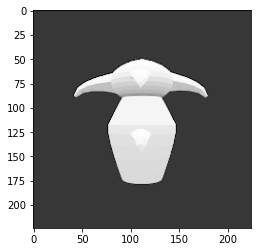

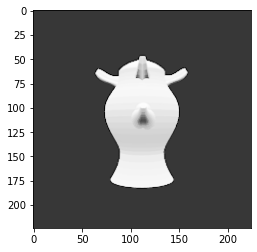

train1: [64.]
train2: [64.]
test: 0.25098039215686274


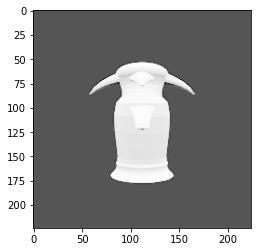

In [5]:
# for sample in x_train:
#     sample[sample == 64.0] = 1.0

from scipy import stats
for i in x_train:
    print(np.max(i))
    print(np.min(i))
    print(stats.mode(i,axis=None))
    print('---------')

colormap = 'Greys_r'
# colormap = 'GnBu'
# colormap = 'viridis'
i1 = 1
i2 = 6
print(np.max(x_train[i1]))
print(np.min(x_train[i1]))
print(np.max(x_train[i2]))
print(np.min(x_train[i2]))

plt.imshow(x_train[i1][:,:,0], cmap=colormap)
# plt.imshow(x_train[i1], cmap=colormap)
plt.show()
plt.imshow(x_train[i2][:,:,0], cmap=colormap)
# plt.imshow(x_train[i2], cmap=colormap)
plt.show()

import cv2
from PIL import Image
im_test_path = r"greebles_10\greebles_tf-specific_all\specific_angle\train\f4_41_lamps_000.png"
im_test_path = os.path.join(os.getcwd(), "greebles_10","greebles_tf-specific_all","specific_angle","train","f4_41_lamps_000.png")

# im_test = cv2.imread(im_test_path,0)
# im_test = np.float64(im_test)
im_test = np.array(Image.open(im_test_path).convert('L'), dtype='float64')
im_test *= (1.0/255)

test_color_bg_idx = [40,40]
print("train1:", x_train[i1][test_color_bg_idx[0], test_color_bg_idx[1]])
print("train2:", x_train[i2][test_color_bg_idx[0], test_color_bg_idx[1]])
print("test:", im_test[test_color_bg_idx[0], test_color_bg_idx[1]])

plt.imshow(im_test, cmap=colormap)
plt.show()
# print(im_test.shape)
# a = (x_train[i2][:,:,0] == im_test)
# print(np.where(a == False))

In [6]:
# Put all the different angles in a dictionary to access individually later
all_test = {}

y_rot = 0
# extra = "upsidedown"; y_rot = 180

test_set_gen_params = [-90, 90, 1]
# test_set_gen_params = [85, 90, 1]

try:
    test_set_name = "greebles10_{}_{}_{}_{}_{}.npy".format(extra,
                    test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2], img_size)
except NameError:
    test_set_name = "greebles10_test_{}_{}_{}_{}.npy".format(
                    test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2], img_size)

test_set_path = os.path.join(source_folder, test_set_name)

if not (os.path.isfile(test_set_path)):
    # Generate test set
    for z in range(test_set_gen_params[0], test_set_gen_params[1] + 1, test_set_gen_params[2]):

        blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                            '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                            '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', str(y_rot), '-zr', str(z)])

        # Move training set to folder                    
        source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
        ltemp.move_to_folder(source_folder, os.path.join(source_folder, "test"))

        print(z, end=", ")
        (x_test, y_test) = ltemp.load_dataset_temp("test", source_folder)
        x_test = np.array(x_test, dtype='float64')
        y_test = np.array(y_test, dtype='float32')

        all_test[str(z)] = (x_test, y_test)
    
    # Save the concatenated set after loop
#     np.save(test_set_path, all_test) #not working with higher res images
    joblib.dump(all_test, test_set_path)


# all_test = np.load(test_set_path, allow_pickle=True).item()
all_test = joblib.load(test_set_path)
print("\n", all_test["90"][0].shape)


 (10, 224, 224, 1)


In [7]:
# all_test_2 = joblib.load(test_set_path)

In [8]:
# # Test for equality
# for z in range(test_set_gen_params[0], test_set_gen_params[1] + 1, test_set_gen_params[2]):
#     i = str(z)
#     a1 = np.array(all_test[i][0])
#     a2 = np.array(all_test_2[i][0])
#     if not np.array_equal(a1,a2):
#         print('nooooo')
# print('Done')

In [9]:
(x_test, y_test) = np.copy(all_test['80'][0]), np.copy(all_test['80'][1])
# IMPORTANT NOTE: The test set is not being normalized here, only training

# Normalize images, try scaling with the stdev. subtract mean and mult by a factor. or just leave them as is.
# x_train *= (1.0/x_train.max())
# x_test *= (1.0/x_test.max())

x_train *= (1.0/255)
x_test *= (1.0/255)

print(np.max(x_train))
print(np.min(x_train))
print(np.max(x_test))
print(np.min(x_test))

class_names = ltemp.get_class_names()
print(class_names)
# print(class_names['train'] == class_names['test'])
print("Classes for confusion matrix")
for idx, c in enumerate(class_names['train']):
    print("{}: {}".format(idx, c))

0.9686274509803922
0.0
0.9686274509803922
0.08627450980392157
{'train': array(['f-1', 'f-2', 'f-3', 'f-4', 'f-5', 'm-1', 'm-2', 'm-3', 'm-4',
       'm-5'], dtype='<U3')}
Classes for confusion matrix
0: f-1
1: f-2
2: f-3
3: f-4
4: f-5
5: m-1
6: m-2
7: m-3
8: m-4
9: m-5


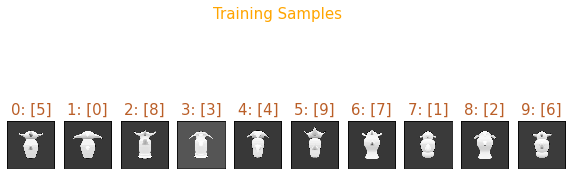

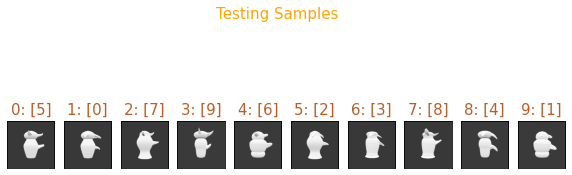

In [10]:
# Step 1.1: Visualize training set and labels
fig, axes = plt.subplots(1,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i][:,:,0], interpolation='nearest', cmap=colormap)
    # ax.imshow(x_train[i], interpolation='nearest', cmap=colormap)
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(1,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0], cmap=colormap)
    # ax.imshow(x_test[i], cmap=colormap)
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [11]:
# Step 2: Create the model
keras.backend.clear_session()
input_shape = (img_size, img_size, 1)
model = Sequential()

# model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(100, activation="relu"))
# model.add(Dense(10, activation="softmax"))

# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=["accuracy"])
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.1), metrics=["accuracy"])
#############################
# model.add(ResNet50(input_shape=(img_size,img_size,1),include_top=False, pooling='avg', weights=None))
# model.add(Dense(10, activation="softmax"))

# model.add(VGG16(input_shape=input_shape,include_top=True, pooling='max', weights=None, classes=10))
# model.add(VGG16(input_shape=input_shape,include_top=False, pooling='max', weights=None, classes=10))

# base_model = VGG16(input_shape=input_shape, include_top=True, pooling='max', weights=None, classes=10)
# print([l.name for l in base_model.layers])
# # from keras.layers import InputLayer
# # model.add(InputLayer(input_shape=input_shape))
# # base_model = VGG16(include_top=False, weights=None, input_shape=input_shape)
# # display(base_model.summary())
# for layer in base_model.layers[:-3]:
#     model.add(layer)

model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(10*2, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.00001), metrics=["accuracy"]
    # loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.1), metrics=["accuracy"]
)

model.summary()
# print([layer.name for layer in model.layers])









_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__

In [12]:
# Step 3: Create the ART classifier
min_pixel_value = 0.0
max_pixel_value = 1.0
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
x_train.shape

(10, 224, 224, 1)

In [14]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=10, nb_epochs=500)
# models_folder_name = "model_" + time.strftime("%Y%m%d_%H%M%S", time.localtime())
classifier.save("model_224_big.h5", path=".")
all_acc = {}

0
Epoch 299/500
1/1 [==============================] - 0s 82ms/step - loss: 4.2195e-04 - acc: 1.0000
Epoch 300/500
1/1 [==============================] - 0s 82ms/step - loss: 3.4814e-04 - acc: 1.0000
Epoch 301/500
1/1 [==============================] - 0s 82ms/step - loss: 3.3136e-04 - acc: 1.0000
Epoch 302/500
1/1 [==============================] - 0s 82ms/step - loss: 2.4397e-04 - acc: 1.0000
Epoch 303/500
1/1 [==============================] - 0s 82ms/step - loss: 8.5824e-05 - acc: 1.0000
Epoch 304/500
1/1 [==============================] - 0s 82ms/step - loss: 3.5204e-04 - acc: 1.0000
Epoch 305/500
1/1 [==============================] - 0s 83ms/step - loss: 2.8845e-04 - acc: 1.0000
Epoch 306/500
1/1 [==============================] - 0s 83ms/step - loss: 3.9043e-04 - acc: 1.0000
Epoch 307/500
1/1 [==============================] - 0s 82ms/step - loss: 4.8952e-04 - acc: 1.0000
Epoch 308/500
1/1 [==============================] - 0s 82ms/step - loss: 1.4824e-04 - acc: 1.0000
Epoch 30

Accuracy on benign test examples: 40.0%
[0 1 2 3 4 5 6 7 8 9] 10
[1 2 5 9] 4
Accuracy Score : 0.4
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      1.00      0.50         1
           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.33      1.00      0.50         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1

    accuracy                           0.40        10
   macro avg       0.20      0.40      0.25        10
weighted avg       0.20      0.40      0.25        10



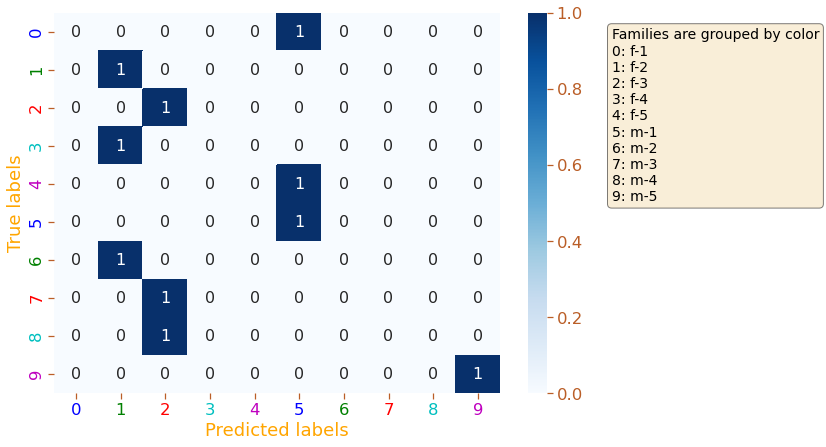

In [15]:
# Step 5: Evaluate the ART classifier on benign test examples
# predictions = classifier.predict(x_train)
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
all_acc['nat'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize, https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7))

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues

plt.xlabel('Predicted labels');
plt.ylabel('True labels');

LABEL_COLOR_MAP = {0: 'b',
                   1: 'g',
                   2: 'r',
                   3: 'c',
                   4: 'm',
                   5: 'orange',
                   6: 'k'
                   }

num_classes = len(class_names['train'])
ax = plt.gca()
for i in range(num_classes):
    c = LABEL_COLOR_MAP[i%(num_classes//2)]
    ax.get_xticklabels()[i].set_color(c)
    ax.get_yticklabels()[i].set_color(c)


textstr = '\n'.join((
    r'$\mu=%.2f$' % (2, ),
    r'$\mathrm{median}=%.2f$' % (5, ),
    r'$\sigma=%.2f$' % (1, )))

textstr = "Families are grouped by color\n" + '\n'.join("{}: {}".format(idx, c) for idx, c in enumerate(class_names['train']))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.90, 0.85, textstr, color='black', transform=plt.gcf().transFigure, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

In [16]:
classifier._model.history.history.keys()

dict_keys(['loss', 'acc'])

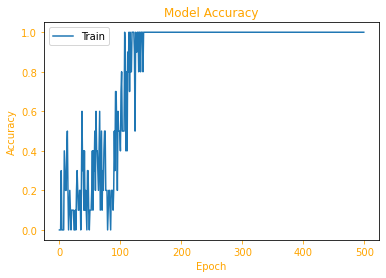

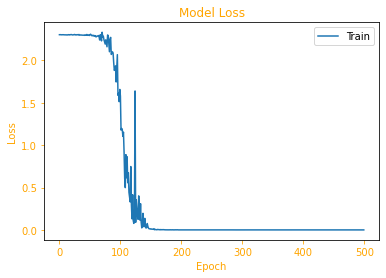

In [17]:
# Training graphs
plt.figure()
ax = plt.gca()
try:
    plt.plot(classifier._model.history.history['acc'])
except KeyError:
    plt.plot(classifier._model.history.history['accuracy'])
plt.ylabel('Accuracy', color="orange")
plt.xlabel('Epoch', color="orange")
plt.legend(['Train'], loc='best')
plt.title('Model Accuracy', color="orange")
ax.tick_params(axis='x', colors="orange")
ax.tick_params(axis='y', colors="orange")

plt.figure()
ax = plt.gca()
plt.plot(classifier._model.history.history['loss'])
plt.ylabel('Loss', color="orange")
plt.xlabel('Epoch', color="orange")
plt.legend(['Train'], loc='best')
plt.title('Model Loss', color="orange")
ax.tick_params(axis='x', colors="orange")
ax.tick_params(axis='y', colors="orange")

plt.show()

In [18]:
all_acc = {}
for k in all_test.keys():
#     (x_test, y_test) = all_test[k]
    (x_test, y_test) = np.copy(all_test[k][0]), np.copy(all_test[k][1])
    # Normalize
    x_test *= (1.0/255)
    # Calculate accuracy
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    all_acc[k] = accuracy
    print("Accuracy on {} degrees: {}%".format(k, accuracy * 100))

Accuracy on -90 degrees: 40.0%
Accuracy on -89 degrees: 40.0%
Accuracy on -88 degrees: 40.0%
Accuracy on -87 degrees: 40.0%
Accuracy on -86 degrees: 40.0%
Accuracy on -85 degrees: 40.0%
Accuracy on -84 degrees: 40.0%
Accuracy on -83 degrees: 40.0%
Accuracy on -82 degrees: 40.0%
Accuracy on -81 degrees: 40.0%
Accuracy on -80 degrees: 40.0%
Accuracy on -79 degrees: 40.0%
Accuracy on -78 degrees: 40.0%
Accuracy on -77 degrees: 40.0%
Accuracy on -76 degrees: 40.0%
Accuracy on -75 degrees: 40.0%
Accuracy on -74 degrees: 40.0%
Accuracy on -73 degrees: 40.0%
Accuracy on -72 degrees: 40.0%
Accuracy on -71 degrees: 40.0%
Accuracy on -70 degrees: 40.0%
Accuracy on -69 degrees: 40.0%
Accuracy on -68 degrees: 40.0%
Accuracy on -67 degrees: 40.0%
Accuracy on -66 degrees: 40.0%
Accuracy on -65 degrees: 40.0%
Accuracy on -64 degrees: 40.0%
Accuracy on -63 degrees: 40.0%
Accuracy on -62 degrees: 40.0%
Accuracy on -61 degrees: 40.0%
Accuracy on -60 degrees: 50.0%
Accuracy on -59 degrees: 50.0%
Accuracy

In [19]:
# for k in all_acc.keys():
# #     print("{};{}".format(k, all_acc[k]))
#     print("{}".format(all_acc[k]))
# classifier.save("model.h5", path=".")

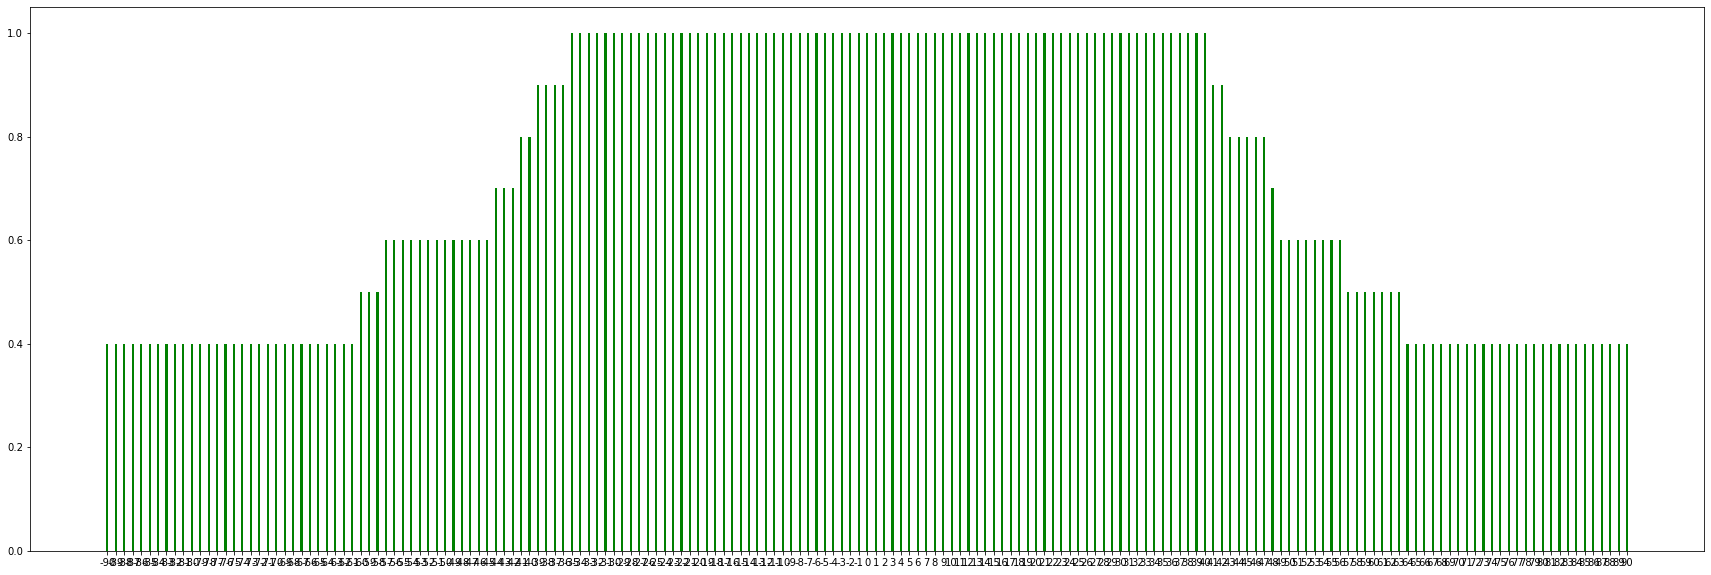

In [20]:
fig = plt.figure(figsize=(30,10))
plt.bar(all_acc.keys(), all_acc.values(), width = 0.25, color='g')
plt.show()

In [21]:
# Clear allocated memory for the GPU
try:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
    print("Cleared memory")
except:
    print("Could not clear memory")

print(time.strftime("%Y/%m/%d; %H:%M:%S", time.localtime()))

Cleared memory
2021/03/18; 17:55:27


In [22]:
# Stop execution early
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
# Step 6: Generate adversarial test examples

# Craft adversarial samples
print("Create adversarial attack")
attack = SpatialTransformation(classifier=classifier, max_translation=10.0, num_translations=1, max_rotation=30.0, num_rotations=1)
# attack = FastGradientMethod(classifier, eps=0.1)
print("Craft attack on training examples")
x_train_adv = attack.generate(x_train)
print("Craft attack test examples")
x_test_adv = attack.generate(x_test)

print(x_train_adv.shape)
print(x_test_adv.shape)

In [ ]:
# Step 6.1: Visualize adversarial samples
fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_adv[i][:,:,0], cmap=colormap)
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test_adv[i][:,:,0], cmap=colormap)
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Test Samples', fontsize=15, color='orange')

plt.show()

In [ ]:
# classifier.save("model.h5", path=".")

In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples before AT: {}%".format(accuracy * 100))
all_acc['adv_before_AT'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7), facecolor='None')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [ ]:
# Step 8: Create adversarial trainer and perform adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)
adv_trainer.fit(x_train_adv, y_train, batch_size=64, nb_epochs=3)

In [ ]:
# Step 9: Evaluate new robustly trained classifier
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples after AT: {}%".format(accuracy * 100))
all_acc['adv_after_AT'] = accuracy * 100

print(all_acc)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))

plt.figure(figsize=(10,7), facecolor='None')

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    hm = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [ ]:
dir(classifier)
# predictions[1]
# np.argmax(predictions, axis=1)
# classifier._loss
# classifier._loss_gradients
classifier.loss_gradient

In [ ]:
# Stop execution early
raise KeyboardInterrupt

In [ ]:
img_size = 224
extra = 'big'
# img_size = 512
model = load_model(os.path.join(os.getcwd(), 'model_{}_{}.h5'.format(img_size, extra)))
model.summary()

In [ ]:
# all_acc = {}
# for k in all_test.keys():
#     (x_test, y_test) = np.copy(all_test[k][0]), np.copy(all_test[k][1])
#     # Normalize
#     x_test *= (1.0/255)
    
#     predictions = classifier.predict(x_test)
#     # accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
#     # all_acc[k] = accuracy
#     # print("Accuracy on {} degrees: {}%".format(k, accuracy * 100))

In [ ]:
(x_test, y_test) = np.copy(all_test[0][0]), np.copy(all_test[0][1])
# Normalize
x_test *= (1.0/255)
predictions = classifier.predict(x_test)

In [ ]:
predictions